## Reconnaissance des émotions des tweets : Traitement du langage naturel avec TensorFlow

---

Ensemble de données : [Ensemble de données d'émotions des tweets](https://github.com/dair-ai/emotion_dataset)

---


## Configuration et importations

1. Importation des bibliothèques
2. Définition des fonctions utiles


In [135]:
%matplotlib inline

# Importation des bibliothèques nécessaires
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import load_dataset

# Fonction pour afficher l'historique d'entraînement (précision et perte)
def show_history(h):
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize=(16, 6))

  plt.subplot(1, 2, 1)
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Entraînement')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
  plt.ylim([0., 1.])
  plt.xlabel('Époques')
  plt.ylabel('Précision')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Entraînement')
  plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
  plt.xlabel('Époques')
  plt.ylabel('Perte')
  plt.legend()
  plt.show()

# Fonction pour afficher la matrice de confusion entre les étiquettes réelles et prédites
def show_confusion_matrix(y_true, y_pred, classes):
  from sklearn.metrics import confusion_matrix
  
  cm = confusion_matrix(y_true, y_pred, normalize='true')
  
  print(classes)

  plt.figure(figsize=(8, 8))
  sp = plt.subplot(1, 1, 1)
  ctx = sp.matshow(cm)
  plt.xticks(list(range(0, len(classes))), labels=classes)
  plt.yticks(list(range(0, len(classes))), labels=classes)
  plt.colorbar(ctx)
  plt.title("Predicted Emotion")
  plt.ylabel("True Emotion")
  plt.show()

# Affichage de la version de TensorFlow utilisée
print('Utilisation de la version TensorFlow', tf.__version__)


Utilisation de la version TensorFlow 2.15.0


## Importation des données

1. Importation de l'ensemble de données d'émotions des tweets
2. Création des ensembles d'entraînement, de validation et de test
3. Extraction des tweets et des étiquettes à partir des exemples


In [78]:
classes_string={0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
# importation de l'ensemble de données
dataset = load_dataset('emotion')

/home/pridos/.local/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [79]:
print("La structure de l'ensemble de données est la suivante :")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [80]:
# stocker les ensembles de données dans des variables
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [81]:
# retourner les tweets et leurs étiquettes
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets, labels

In [82]:
tweets, labels = get_tweet(train)

In [83]:
# afficher les 5 premiers tweets et leurs étiquettes
for i in range(5):
  print(f"('{tweets[i]}', '{classes_string[labels[i]]}')")

('i didnt feel humiliated', 'sadness')
('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'sadness')
('im grabbing a minute to post i feel greedy wrong', 'anger')
('i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'love')
('i am feeling grouchy', 'anger')


## Tokenizer

1. Tokenisation des tweets


In [84]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [85]:
# Création d'un tokenizer pour les données textuelles et ajustement sur les tweets
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [86]:
# Conversion des tweets en séquences d'entiers
print(tweets[1])
tokenizer.texts_to_sequences([tweets[1]])

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

## Remplissage et troncature des séquences

1. Vérification de la longueur des tweets
2. Création de séquences remplies


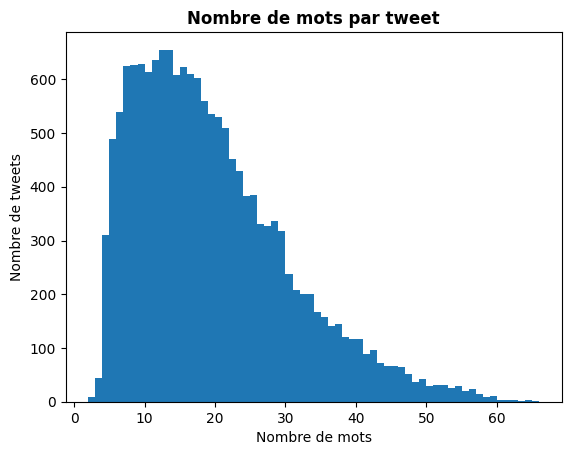

In [107]:
#Affiche un histogramme représentant le nombre de mots par tweet.
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.title("Nombre de mots par tweet", fontweight="bold")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de tweets")
plt.show()


In [88]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [89]:
# Retourner une version des tweets sous forme de séquences
# d'entiers de longueur fixe
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [90]:
padded_train_seq=get_sequences(tokenizer, tweets)

In [91]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Préparation des étiquettes

1. Création des dictionnaires de correspondance entre les classes et les index, et entre les index et les classes
2. Conversion des étiquettes textuelles en étiquettes numériques


In [92]:
# classes_string=["sadness", "joy", "love", "anger", "fear", "surprise"]
classes=set(labels)
print([classes_string[i] for i in classes])

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


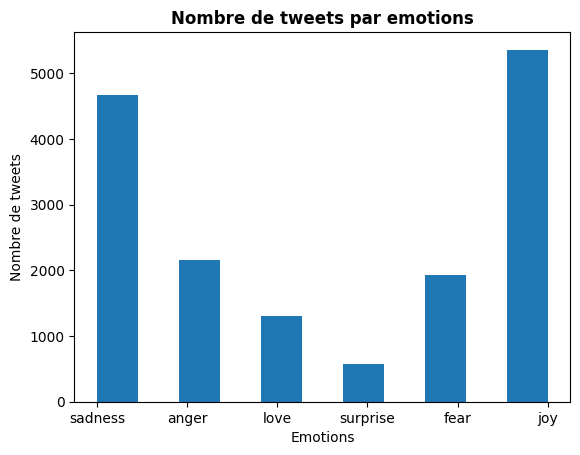

In [93]:
label_strings = [classes_string[label] for label in labels]
plt.hist(label_strings, bins=11)
plt.title("Nombre de tweets par emotions", fontweight="bold")
plt.xlabel("Emotions")
plt.ylabel("Nombre de tweets")
plt.show()

In [94]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [95]:
names_to_indexes=lambda labels: np.array([class_to_index.get(x) for x in labels ])

In [96]:
train_labels=names_to_indexes(labels)

## Création du modèle

1. Création du modèle
2. Compilation du modèle


In [97]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),
  tf.keras.layers.Dense(6, activation='softmax')
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [98]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 50, 40)            9760      
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                      

## Entraînement du modèle

1. Préparation d'un ensemble de validation
2. Entraînement du modèle


In [99]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_indexes(val_labels)

In [100]:
val_labels

array([0, 0, 2, ..., 1, 1, 1])

Epoch 1/20
500/500 [==============================] - 23s 38ms/step - loss: 1.2206 - accuracy: 0.5231 - val_loss: 0.7040 - val_accuracy: 0.7825
Epoch 2/20
500/500 [==============================] - 19s 39ms/step - loss: 0.4776 - accuracy: 0.8385 - val_loss: 0.5188 - val_accuracy: 0.8375
Epoch 3/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2796 - accuracy: 0.9112 - val_loss: 0.4053 - val_accuracy: 0.8695
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2043 - accuracy: 0.9358 - val_loss: 0.3819 - val_accuracy: 0.8860
Epoch 5/20
500/500 [==============================] - 18s 37ms/step - loss: 0.1530 - accuracy: 0.9531 - val_loss: 0.3593 - val_accuracy: 0.8865
Epoch 6/20
500/500 [==============================] - 19s 38ms/step - loss: 0.1292 - accuracy: 0.9604 - val_loss: 0.3703 - val_accuracy: 0.8805
Epoch 7/20
500/500 [==============================] - 19s 37ms/step - loss: 0.1118 - accuracy: 0.9660 - val_loss: 0.3567 - val_accuracy:

INFO:tensorflow:Assets written to: ./model.tf/assets


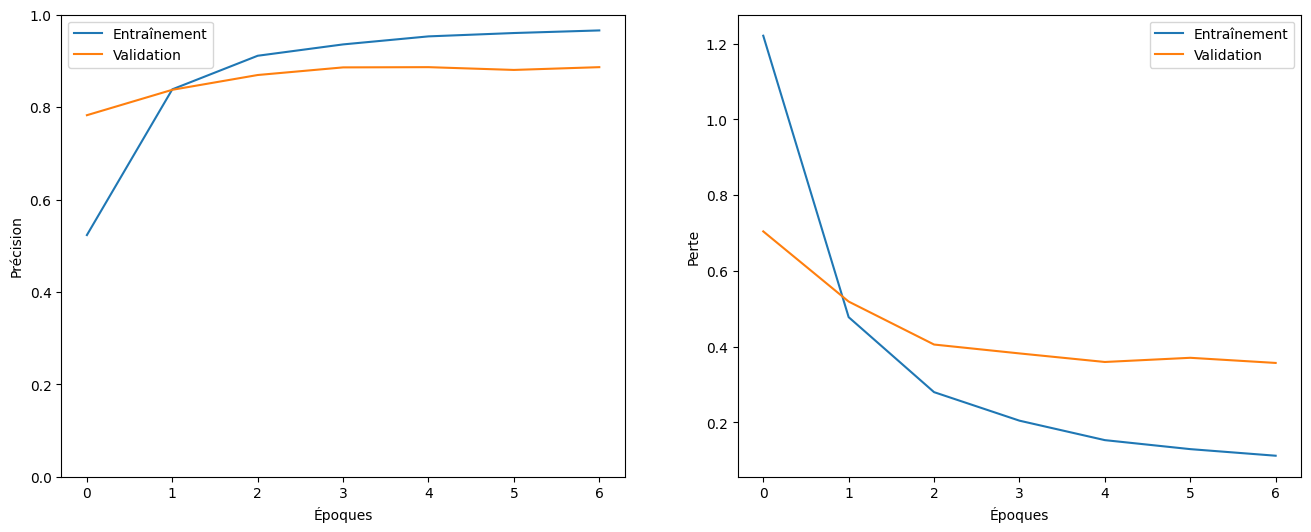

In [101]:
model_path = './model.tf'

# Vérifier si le fichier du modèle existe
if os.path.exists(model_path):
  # Charger le modèle s'il existe
  model = keras.models.load_model(model_path)
else:
  # Entraîner le modèle si le fichier du modèle n'existe pas
  hypothese = model.fit(
    x=padded_train_seq,
    y=train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
  )
  # Sauvegarder le modèle entraîné
  model.save(model_path)
  show_history(hypothese)


## Évaluation du modèle

1. Visualisation de l'historique de l'entraînement
2. Préparation d'un ensemble de test
3. Un aperçu des prédictions individuelles sur l'ensemble de test
4. Un aperçu de toutes les prédictions sur l'ensemble de test


In [102]:
# Retourner les tweets et leurs étiquettes pour l'ensemble de test 
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_indexes(test_labels)

In [109]:
# Evaluation du modèle sur l'ensemble de test
_ = model.evaluate(x=test_sequences, y=test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.3843 - accuracy: 0.8820


50

In [104]:
# Prédiction de l'émotion d'un tweet insere par l'utilisateur
input_tweet = input("Enter a tweet to predict its emotion: ")

preprocessed_tweet = get_sequences(tokenizer, [input_tweet])

i_prediction = model.predict(preprocessed_tweet)[0]

# Resultat de la prédiction
predicted_class = index_to_class[np.argmax(i_prediction).astype('uint8')]

print(f'\nTweet : {input_tweet}')
print(f'Predicted Emotion : {classes_string[predicted_class]}')

1/1 [==============================] - 1s 1s/step

Tweet : i am scared
Predicted Emotion : fear


In [133]:
# Prédiction de l'émotion de l'ensemble de test
# pour la matrice de confusion
predictions = model.predict(test_sequences)
predicted_classes = np.argmax(predictions, axis=1)
string_predicted_classes = [classes_string[p] for p in set(predicted_classes)]
string_predicted_classes

63/63 [==============================] - 1s 17ms/step


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


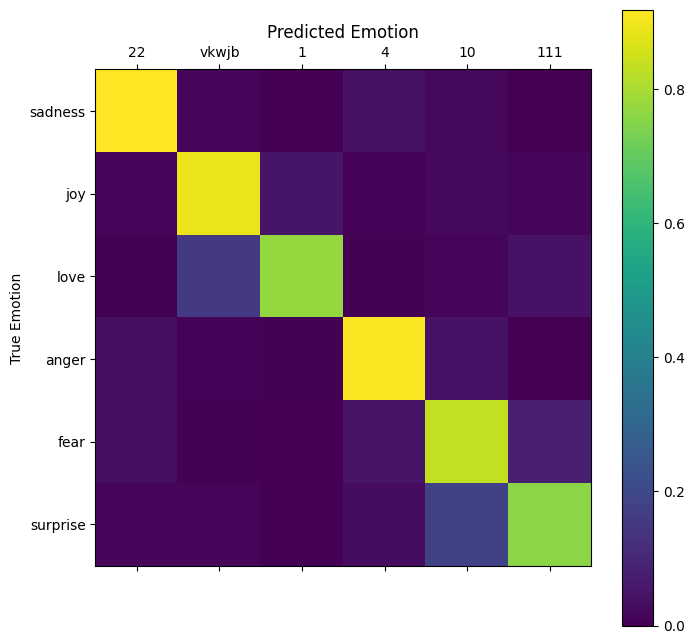

In [136]:
# Presentation de la matrice de confusion
show_confusion_matrix(test_labels, predicted_classes, string_predicted_classes)